<a href="https://colab.research.google.com/github/sagar-rathod/PytorchDeepML/blob/master/examples/Image%20Regression%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Regression Example

In this example, we will see how to solve [Cube Orientation Problem](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/orientme) hosted on AICrowd using deepml. 

First, lets download the train and test dataset

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.2/training.tar.gz
!tar -xzf training.tar.gz
!rm training.tar.gz

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.2/test.tar.gz
!tar -xzf test.tar.gz
!rm  test.tar.gz

Once downloaded and extracted, we can check the number of images in **tranining** folder

In [ ]:
# Number of train images
!ls training/images | wc -l

In [ ]:
# Number of test Images
!ls images | wc -l

Install [deepml](https://github.com/sagar-rathod/PytorchDeepML) libarary.

In [ ]:
!pip install git+https://github.com/sagar-rathod/PytorchDeepML.git

Once successfuly installed, lets import the number of required libraries and set a **seed** value

In [ ]:
import pandas as pd
import numpy as np
import torch

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['text.color'] = 'white'

seed = 7

np.random.seed(seed)
torch.random.manual_seed(seed)

In [ ]:
train_dir = 'training/images'
labels_file = 'training/labels.csv'
test_dir = 'images'

For this problem, we have been provided the separate label file for training set, so let's read that and see some contents.

In [ ]:
labels_df = pd.read_csv(labels_file)
labels_df['xRot'] = labels_df['xRot'].astype(np.float32)
labels_df.head()

,filename,xRot
0,000000.jpg,336.838887
1,000001.jpg,148.484378
2,000002.jpg,244.821661
3,000003.jpg,222.700630
4,000004.jpg,172.358121


As usually in any ML problem, we divide the provided training dataset in two parts: train and validation. Let's do that.

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(labels_df, random_state=seed)
train.shape, val.shape

((3750, 2), (1250, 2))

We are going to use **ImageNet** pretrained **resnet18** model for this problem. As it accepts **224** size of image as input, we have to define torch transformation for training and validation dataset

In [ ]:
import torchvision
from deepml.datasets import ImageFileDataFrameDataset
from deepml import constants

transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.CenterCrop(224),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=constants.IMAGENET_MEAN, std=constants.IMAGENET_STD, inplace=True),
                                             ])

<p> As in case our input dataframe, we need to provide imagw file path column name where these images will be looked up inside train dir. </p>
<p>Also provide target column name which isxRot that we need to predict the rotation of cubic image. </p>

In [ ]:
train_dataset = ImageFileDataFrameDataset(train, img_file_path_column='filename', target_column='xRot', image_dir=train_dir, transforms=transforms)
val_dataset = ImageFileDataFrameDataset(val, img_file_path_column='filename', target_column='xRot', image_dir=train_dir, transforms=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

Let's visiualise some images from tranining set. As we have provided Imagenet mean and std_dev to transform input images, similarly we need to provide Imagenet reverse transorm to visualize it properly. However this is optional and you may receive warnings

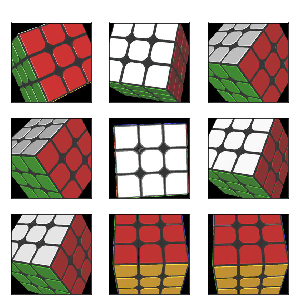

In [ ]:
from deepml.transforms import ImageNetInverseTransform
from deepml.utils import show_images_from_loader

inverse_transform = ImageNetInverseTransform()

show_images_from_loader(train_loader, image_inverse_transform=inverse_transform)

Now let see how to quickly train model using **deepml**.

Create **resnet18** model and modify it's head/last layer because we need to predict **single floating integer**, that is the degree of cube orientation between 0 and 360 degree. 

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

# freeze early layers
for param in model.parameters():
    if param.requires_grad:
        param.requires_grad = False

# Modify head
model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

Choose loss function, optimizer and create **deepml.train.Learner** object.

In [ ]:
from deepml.losses import RMSELoss
from torch.nn import MSELoss
from deepml.train import Learner

criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

work_dir = 'resnet18'
learner = Learner(model, optimizer, work_dir, use_gpu=True)

**deepml** logs its training and validation metrics into tensorboard while model learns from the data. You can also visualize random training images and model prediction in tensorboard/Images section.

In [ ]:
# Enable Tensorboard on colab
%load_ext tensorboard

# Run tensorboard and provide model working directory
%tensorboard --logdir 'resnet18'

Let's fit the learner on train loader and use tensorboard to monitor training progress

In [ ]:
# Here, we are passing inverse transform to see those images on tensorboard

#metrics to evaluate 
metrics = [MSELoss()]

learner.fit(criterion, train_loader, val_loader, epochs=10, show_progress=True, image_inverse_transform=inverse_transform,
            metrics=metrics)

Epoch 1/10:


Saving best validation model.
Epoch: 1/10	Train Loss: 196.277102	Val Loss: 189.020164
Epoch 2/10:


Saving best validation model.
Epoch: 2/10	Train Loss: 177.992813	Val Loss: 171.661706
Epoch 3/10:


Saving best validation model.
Epoch: 3/10	Train Loss: 161.904460	Val Loss: 155.819347
Epoch 4/10:


Saving best validation model.
Epoch: 4/10	Train Loss: 146.878231	Val Loss: 142.573125
Epoch 5/10:


Saving best validation model.
Epoch: 5/10	Train Loss: 134.091865	Val Loss: 129.721641
Epoch 6/10:


Saving best validation model.
Epoch: 6/10	Train Loss: 123.485356	Val Loss: 118.708532
Epoch 7/10:


Saving best validation model.
Epoch: 7/10	Train Loss: 115.522148	Val Loss: 112.992419
Epoch 8/10:


Saving best validation model.
Epoch: 8/10	Train Loss: 109.582694	Val Loss: 107.362775
Epoch 9/10:


Saving best validation model.
Epoch: 9/10	Train Loss: 105.688214	Val Loss: 104.331130
Epoch 10/10:


Saving best validation model.
Epoch: 10/10	Train Loss: 102.948907	Val Loss: 100.111291


In [ ]:
# Save model weights
learner.save('current_model.pt', save_optimizer_state=True, epoch=10)

'resnet18\\current_model.pt'

Let's, see some random samples of prediction from validation data

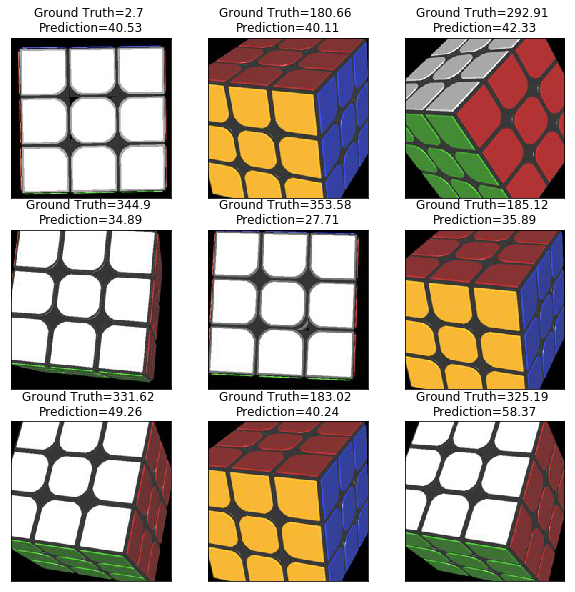

In [ ]:
learner.show_predictions(val_loader, image_inverse_transform=inverse_transform)

Once the model is trained, lets use it to perform prediction on test data. Since provided test data is list of images in a folder. We can use ImageListDataset

In [ ]:
from deepml.datasets import ImageListDataset
 
test_dataset = ImageListDataset('images', transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=4)
test_predictions, filenames = learner.predict(test_loader)

Read provided sample submission file and create our final submission csv.

In [ ]:
submission = pd.read_csv("https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.2/sample_submission.csv")
submission.head()

,xRot,filename
0,187.513045,005000.jpg
1,36.193195,005001.jpg
2,168.197639,005002.jpg
3,62.259594,005003.jpg
4,126.537186,005004.jpg


In [ ]:
submission['xRot'] = test_predictions.numpy()
submission['filename'] = filenames

submission.head()

,xRot,filename
0,37.052364,005000.jpg
1,42.557499,005001.jpg
2,41.109123,005002.jpg
3,40.397060,005003.jpg
4,37.757359,005004.jpg


In [ ]:
submission.to_csv('submission.csv', index=False)